In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import uqer
import numpy as np
import pandas as pd
from uqer import DataAPI as api
from alphamind.api import *
from alphamind.data.neutralize import neutralize

plt.style.use('ggplot')

In [2]:
_ = uqer.Client(token='')

16937@wmcloud.com 账号登录成功


In [3]:
ref_date = '2017-06-23'
factor = 'EPS'

engine = SqlEngine()
universe = Universe('custom', ['zz800'])

# Algorithm Description
--------------------------

猜测的 ``neutralize`` 残差$\bar Res$计算公式：

$$\bar Res_{i,k} = \bar f_{i,k} - \sum_j \beta_{j,k} \times \bar Ex_{i, j, k}$$

其中：$k$为行业分类，$i$为该行业中第$i$只股票，$j$为第$j$个风险因子。$\bar f$为因子序列，$\bar Ex$为风险暴露矩阵。系数$\beta_{j,k}$由OLS确定。

下面的章节，我们分别比较三种``neutralize``的方法差别：

* **UQER Neutralize**

    使用优矿的SDK计算因子残差。


* **Alpha-Mind Neutralize**

    使用alpha-mind计算因子残差，alpha-mind可以由以下地址安装：
    
    ```
    https://github.com/wegamekinglc/alpha-mind
    ```

* **Direct Weighted Least Square Fit Implementation**

    直接使用scikit-learn的线性回归功能来计算因子残差。


# Raw Data
---------------------------

In [4]:
codes = engine.fetch_codes(ref_date, universe)
factor_data = engine.fetch_factor(ref_date, factor, codes)
risk_cov, risk_expousre = engine.fetch_risk_model(ref_date, codes)
total_data = pd.merge(factor_data, risk_expousre, on=['code']).dropna()

In [5]:
total_data['ticker'] = total_data.code.apply(lambda x: '{0:06}'.format(x))
total_data.set_index('ticker', inplace=True)

In [6]:
len(total_data)

800

# UQER Neutralize
-----------------------

In [7]:
%%time
neutralized_factor_uqer = uqer.neutralize(total_data[factor],
                                          target_date=ref_date.replace('-', ''),
                                          industry_type='short')

CPU times: user 6.95 ms, sys: 3.42 ms, total: 10.4 ms
Wall time: 122 ms


In [8]:
df = pd.DataFrame(neutralized_factor_uqer, columns=['uqer'])
df.head(10)

,uqer
000001,-0.065580
000002,-0.279003
000006,-0.044765
000008,-0.049037
000009,0.011354
000012,0.084542
000021,0.047019
000025,-0.045585
000027,-0.014162
000028,0.352680


In [9]:
len(neutralized_factor_uqer)

800

In [10]:
risk_exposure_uqer = uqer.DataAPI.RMExposureDayGet(tradeDate=ref_date.replace('-', '')).set_index('ticker')
targeted_secs = risk_exposure_uqer.loc[neutralized_factor_uqer.index]

style_exposure = neutralized_factor_uqer.values @ targeted_secs[risk_styles].values
industry_exposure = neutralized_factor_uqer.values @ targeted_secs[industry_styles].values

exposure = pd.Series(np.concatenate([style_exposure, industry_exposure]), index=risk_styles+industry_styles)
exposure

BETA             -7.079814e-01
MOMENTUM          5.939448e-01
SIZE             -6.938956e-01
EARNYILD          1.338850e+00
RESVOL            2.322437e-01
GROWTH           -2.983247e+00
BTOP              1.012006e-01
LEVERAGE          3.958701e-02
LIQUIDTY         -6.292967e-01
SIZENL            4.881117e-04
Bank             -1.998401e-14
RealEstate       -1.243450e-14
Health            1.454392e-14
Transportation   -6.106227e-16
Mining           -1.282308e-14
NonFerMetal      -2.775558e-17
HouseApp          2.886580e-15
LeiService       -4.996004e-16
MachiEquip        9.547918e-15
BuildDeco        -5.329071e-15
CommeTrade        7.216450e-15
CONMAT           -6.772360e-15
Auto             -3.594347e-15
Textile           5.412337e-15
FoodBever         4.329870e-15
Electronics       1.998401e-15
Computer          3.719247e-15
LightIndus        6.133982e-15
Utilities         3.053113e-16
Telecom          -4.163336e-15
AgriForest        1.845746e-15
CHEM              4.579670e-15
Media   

# Alpha-Mind Neutralize
--------------------------

In [11]:
x = total_data[risk_styles + industry_styles].values
y = total_data[factor].values

In [12]:
%%time
neutralized_factor_alphamind = neutralize(x, y, weights=np.ones(len(y)))

CPU times: user 1.59 s, sys: 8.02 ms, total: 1.6 s
Wall time: 152 ms


In [13]:
alphamind_series = pd.Series(neutralized_factor_alphamind.flatten(), index=total_data.index)
df['alpha-mind'] = alphamind_series
df.head()

,uqer,alpha-mind
000001,-0.065580,-0.076975
000002,-0.279003,-0.288382
000006,-0.044765,-0.054668
000008,-0.049037,-0.034123
000009,0.011354,0.029815


In [14]:
len(alphamind_series)

800

# The Ticker Missing in UQER but Still in Alpha-Mind
-----------------------------------

In [15]:
missed_codes = [c for c in alphamind_series.index if c not in neutralized_factor_uqer.index]

In [16]:
total_data.loc[missed_codes]

,code,isOpen,EPS,s_srisk,BETA,MOMENTUM,SIZE,EARNYILD,RESVOL,GROWTH,...,Telecom,AgriForest,CHEM,Media,IronSteel,NonBankFinan,ELECEQP,AERODEF,Conglomerates,COUNTRY
ticker,,,,,,,,,,,,,,,,,,,,,


# Direct Weighted Least Square Fit Implementation
------------------------

In [17]:
import statsmodels.api as sm

/home/python/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [18]:
mod = sm.WLS(y, x, weights=np.ones(len(y))).fit()
lg_series = pd.Series(mod.resid, index=total_data.index)

In [19]:
df['ols'] = lg_series

# Comparison
------------------

In [20]:
df['uqer - ols'] = df['uqer'] - df['ols']
df['alphamind - ols'] = df['alpha-mind'] - df['ols']

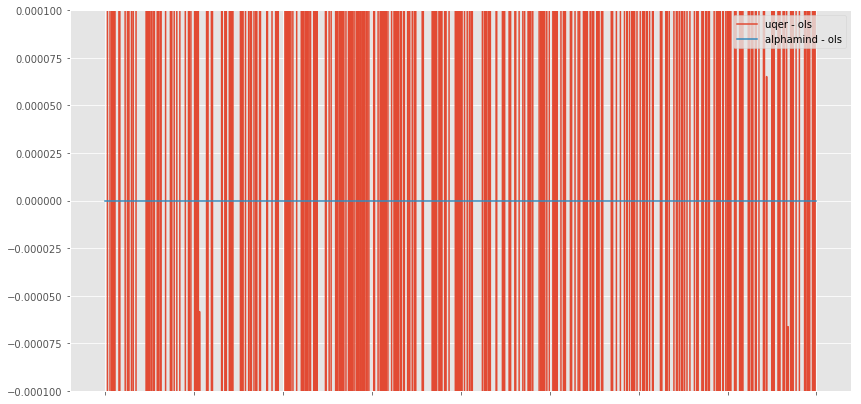

In [21]:
df[['uqer - ols', 'alphamind - ols']].plot(figsize=(14, 7), ylim=(-1e-4, 1e-4))

In [22]:
df.head()

,uqer,alpha-mind,ols,uqer - ols,alphamind - ols
000001,-0.065580,-0.076975,-0.076975,0.011395,5.551115e-17
000002,-0.279003,-0.288382,-0.288382,0.009378,0.000000e+00
000006,-0.044765,-0.054668,-0.054668,0.009904,7.494005e-16
000008,-0.049037,-0.034123,-0.034123,-0.014914,-6.106227e-16
000009,0.011354,0.029815,0.029815,-0.018461,2.498002e-16
